# Capstone 3 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [178]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from IPython.display import Image
%matplotlib inline

In [179]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [185]:
# load the combined csv file
df = pd.read_csv('combined.csv')
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1/31/1996,263374,1
1,90250,Los Angeles County,1/31/1996,184141,1
2,90046,Los Angeles County,1/31/1996,119677,1
3,94501,Alameda County,1/31/1996,119742,1
4,94110,San Francisco County,1/31/1996,221428,1


In [186]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df1 = df1.sort_values(['Date','Zipcode'])
df2 = df.loc[df['Bedrooms']==2]
df2 = df2.sort_values(['Date','Zipcode'])
df3 = df.loc[df['Bedrooms']==3]
df3 = df3.sort_values(['Date','Zipcode'])
df4 = df.loc[df['Bedrooms']==4]
df4 = df4.sort_values(['Date','Zipcode'])
df1.head()

,Zipcode,County,Date,Value,Bedrooms
22,90004,Los Angeles County,1/31/1996,139486,1
201,90007,Los Angeles County,1/31/1996,96265,1
203,90012,Los Angeles County,1/31/1996,108276,1
111,90016,Los Angeles County,1/31/1996,103716,1
113,90018,Los Angeles County,1/31/1996,167823,1


# Preprocess for VARMAX model
need the values to be differenced first then 1/5 root it

In [187]:
# define a function that takes in the df, and the number of diff value and root value (needs to be odd numbers)
def data_trans(df, val_name):
    temp = pd.DataFrame({})
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # difference the data
    temp = temp.diff().dropna()
    # get make the dataset 1/5 root
    for zipcode in list(df.Zipcode.unique()):
        temp[zipcode] = temp[zipcode].apply(lambda x: (x**(1/5)))
    # add Date column to so we can melt it
    temp['Date'] = pd.date_range('1996-02-29', periods=292, freq='M')
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in float since it has imaginary number
    temp_sort[val_name] = temp_sort[val_name].astype('float64')
    # set the Date as index
    temp_sort.set_index('Date', inplace=True)
    return temp_sort

In [188]:
df1t = data_trans(df1, 'OneBR')
df2t = data_trans(df2, 'TwoBR')
df3t = data_trans(df3, 'ThreeBR')
df4t = data_trans(df4, 'FourBR')
dft = df1t
dft['TwoBR'] = df2t.TwoBR
dft['ThreeBR'] = df3t.ThreeBR
dft['FourBR'] = df4t.FourBR
dft

,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
Date,,,,,
1996-02-29,90004,5.7229,3.5275,4.5316,5.7095
1996-02-29,90007,6.0493,5.8634,5.6265,5.3385
1996-02-29,90012,6.4298,6.5690,2.0787,3.4114
1996-02-29,90016,5.2332,4.6321,4.1752,4.7291
1996-02-29,90018,5.1409,3.7724,4.2126,4.3607
...,...,...,...,...,...
2020-05-31,95821,5.7583,6.3989,6.4684,5.4882
2020-05-31,95822,7.4284,4.9751,6.5310,6.6603
2020-05-31,95825,6.1956,5.5046,6.3310,6.6666


# Modeling

In [189]:
# iterate to model/fit/predict
# create dfs to store values
pred_df1 = pd.DataFrame({'Date':pd.date_range('2015-06-30', periods=60, freq='M')})
pred_df2 = pred_df1
pred_df3 = pred_df1
pred_df4 = pred_df1
# iterate thru zip and get the values stored; order=(1,0) trend='n' since the data is stationary
start = time.time()
for zipcode in list(dft.Zipcode.unique()):
    # get the endog by subsetting the dft with specific zipcode
    endog = dft[dft['Zipcode']==zipcode][[i for i in list(dft.columns)][1:]]
    # train/fit the model
    model = sm.tsa.VARMAX(endog, order=(1,0), trend='n')
    result = model.fit(maxiter=1000, disp=False)
    # forecast
    pred = result.predict(start=(len(endog)), end=(len(endog)+59))
    # append data to dataframes
    pred_df1[zipcode] = list(pred.OneBR)
    pred_df2[zipcode] = list(pred.TwoBR)
    pred_df3[zipcode] = list(pred.ThreeBR)
    pred_df4[zipcode] = list(pred.FourBR)
# stop timer
end = time.time()
fit_time = (end-start)
#check the fit time in min
int(fit_time/60)

13

# Transform predictions back to original format

In [113]:
# create a function to inverse the diff by having the first value
def diff_inv(df_diff, first_value):
    df = np.r_[first_value, df_diff].cumsum().astype(int)
    return df

In [114]:
# test the function above
x = pd.Series([3,7,2,6,8,0,5,0,4,9,5])
x_diff = x.diff().dropna()
diff_inv(x_diff, 3)

array([3, 7, 2, 6, 8, 0, 5, 0, 4, 9, 5])

In [162]:
list(pred_df1[90004].apply(lambda x: (x**(5))))

[28817.410461411808,
 35007.29983073322,
 36583.02151210139,
 35244.8614502061,
 32541.228341830363,
 29348.25889016454,
 26129.76040564588,
 23098.22377042389,
 20337.27604903421,
 17866.639691074455,
 15676.71826616368,
 13745.709764269155,
 12047.904716572279,
 10557.527888995002,
 9250.402858910535,
 8104.567434337695,
 7100.398331280537,
 6220.516833308917,
 5449.606362621933,
 4774.203777935337,
 4182.492604011938,
 3664.1101714582187,
 3209.972924895454,
 2812.1205759306013,
 2463.5781985034637,
 2158.234744243159,
 1890.7362859886196,
 1656.392332028423,
 1451.0936732559435,
 1271.240374051881,
 1113.678669339932,
 975.6456735925279,
 854.7209382642445,
 748.7840111443137,
 655.977254860191,
 574.6732732484684,
 503.4463747494056,
 441.04757259546017,
 386.38268349672137,
 338.49314081702744,
 296.53918581337376,
 259.78514220120593,
 227.58651583504215,
 199.37869329543247,
 174.66704120943083,
 153.01823269348668,
 134.05264882537568,
 117.43772190263061,
 102.88210375940523,

In [163]:
# define a function that will revert back the prediction values
def pred_trans(pred_df, original_df, val_name):
    temp = pd.DataFrame({})    
    for col in list(pred_df.columns)[1:]:
        # let's inverse the 1/5 root
        temp[col] = list(pred_df[col].apply(lambda x: (x**(5))))
    for col in list(pred_df.columns)[1:]:
        # inverse the diff()
        original_values = list(original_df[original_df['Zipcode']==col].Value)
        first_value = original_values[-1]
        temp[col] = list(diff_inv(pred_df[col], first_value))[:60]
    temp['Date']=pred_df['Date']
    # melt and sort
    temp_melt = pd.melt(temp, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    temp_sort = temp_melt.sort_values(['Date','Zipcode'])
    # have the Values in int so it's easier to read and compared to original values
    temp_sort[val_name] = temp_sort[val_name].astype('int64')
    return temp_sort

In [164]:
# # transform and compile the prediction
# pred_dft = pred_trans(pred_df1, df1, 'OneBR')
# pred_dft2 = pred_trans(pred_df2, df2, 'TwoBR')
# pred_dft3 = pred_trans(pred_df3, df3, 'ThreeBR')
# pred_dft4 = pred_trans(pred_df4, df4, 'FourBR')
# pred_dft['TwoBR'] = pred_dft2.TwoBR
# pred_dft['ThreeBR'] = pred_dft3.ThreeBR
# pred_dft['FourBR'] = pred_dft4.FourBR
# pred_dft.head()
# # save the sorted ddpred with similar style as test
# pred_dft.to_csv('varmax_forecast.csv', index=False)

In [165]:
# load the transformed data
pred_dft = pd.read_csv('varmax_forecast.csv')
pred_dft.head()

,Date,Zipcode,OneBR,TwoBR,ThreeBR,FourBR
0,2020-06-30,90004,650635,947960,1244873,2060165
1,2020-06-30,90007,549631,636873,719875,809658
2,2020-06-30,90012,505948,636397,748877,831766
3,2020-06-30,90016,511499,723789,846441,927705
4,2020-06-30,90018,578671,724873,778523,839241


In [166]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[240+481*i][val_column]
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means
# define a function that takes in the df (the very first excel file) and bedroom number to get the median
def z_median_calc(df, BR):
    z_medians = []
    df_sub = df[df['Bedrooms']==BR] # subset to corresponding bedroom number
    df_sub = df_sub.sort_values(['Date','Value']) # sort by date then Value so we can find the median
    for i in range(0,293): # 293 months of data
        median = df_sub.iloc[240+481*i].Value #the 241st, since zero index 240
        z_medians.append(int(median))
    return z_medians
# do the same to get the z_mean
def z_mean_calc(df, BR):
    z_means = []
    df_sub = df[df['Bedrooms']==BR]
    for i in list(df_sub.Date.unique()): # get the dates to iterate
        mean = df_sub[df_sub['Date']==i].Value.mean() # get the mean
        z_means.append(int(mean))
    return z_means

In [169]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_df = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')})
z_df['z_median_OneBR'] = z_median_calc(df,1)
z_df['z_median_TwoBR'] = z_median_calc(df,2)
z_df['z_median_ThreeBR'] = z_median_calc(df,3)
z_df['z_median_FourBR'] = z_median_calc(df,4)
z_df['z_mean_OneBR'] = z_mean_calc(df,1)
z_df['z_mean_TwoBR'] = z_mean_calc(df,2)
z_df['z_mean_ThreeBR'] = z_mean_calc(df,3)
z_df['z_mean_FourBR'] = z_mean_calc(df,4)
# do the same for prediction
p_df = pd.DataFrame({'Date':pd.date_range('2020-06-30', periods=60, freq='M')})
p_df['p_median_OneBR'] = median_calc(pred_dft, 60, 'OneBR')
p_df['p_median_TwoBR'] = median_calc(pred_dft, 60, 'TwoBR')
p_df['p_median_ThreeBR'] = median_calc(pred_dft, 60, 'ThreeBR')
p_df['p_median_FourBR'] = median_calc(pred_dft, 60, 'FourBR')
p_df['p_mean_OneBR'] = mean_calc(pred_dft, 'OneBR')
p_df['p_mean_TwoBR'] = mean_calc(pred_dft, 'TwoBR')
p_df['p_mean_ThreeBR'] = mean_calc(pred_dft, 'ThreeBR')
p_df['p_mean_FourBR'] = mean_calc(pred_dft, 'FourBR')

In [170]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
z_melt.head()

,Date,variable,value
0,1996-01-31,z_median_OneBR,126629
1,1996-02-29,z_median_OneBR,125105
2,1996-03-31,z_median_OneBR,129803
3,1996-04-30,z_median_OneBR,138193
4,1996-05-31,z_median_OneBR,150678


In [174]:
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in z_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in z_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
z_melt['measure_type'] = measure_list
z_melt['Bedrooms'] = BR_list
z_melt['Source'] = 'Zillow'
display(z_melt.head(3))
z_melt.tail(3)

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,125105,median,1,Zillow
2,1996-03-31,z_median_OneBR,129803,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
2341,2020-03-31,z_mean_FourBR,1200260,mean,4,Zillow
2342,2020-04-30,z_mean_FourBR,1202760,mean,4,Zillow
2343,2020-05-31,z_mean_FourBR,1200397,mean,4,Zillow


In [173]:
# do the same for prediction values' mean/medians
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
p_melt = pd.melt(p_df, ['Date'])
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in p_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in p_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
p_melt['measure_type'] = measure_list
p_melt['Bedrooms'] = BR_list
p_melt['Source'] = 'VARMAX'
display(p_melt.head(3))
p_melt.tail(3)

,Date,variable,value,measure_type,Bedrooms,Source
0,2020-06-30,p_median_OneBR,469552,median,1,VARMAX
1,2020-07-31,p_median_OneBR,469560,median,1,VARMAX
2,2020-08-31,p_median_OneBR,469568,median,1,VARMAX


,Date,variable,value,measure_type,Bedrooms,Source
477,2025-03-31,p_mean_FourBR,1167502,mean,4,VARMAX
478,2025-04-30,p_mean_FourBR,1167503,mean,4,VARMAX
479,2025-05-31,p_mean_FourBR,1167504,mean,4,VARMAX


In [175]:
# concat both dataframes so we can graph everything using seaborn
sea_df = pd.concat([z_melt, p_melt])
display(sea_df.head(3))
sea_df.tail(3)

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,125105,median,1,Zillow
2,1996-03-31,z_median_OneBR,129803,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
477,2025-03-31,p_mean_FourBR,1167502,mean,4,VARMAX
478,2025-04-30,p_mean_FourBR,1167503,mean,4,VARMAX
479,2025-05-31,p_mean_FourBR,1167504,mean,4,VARMAX


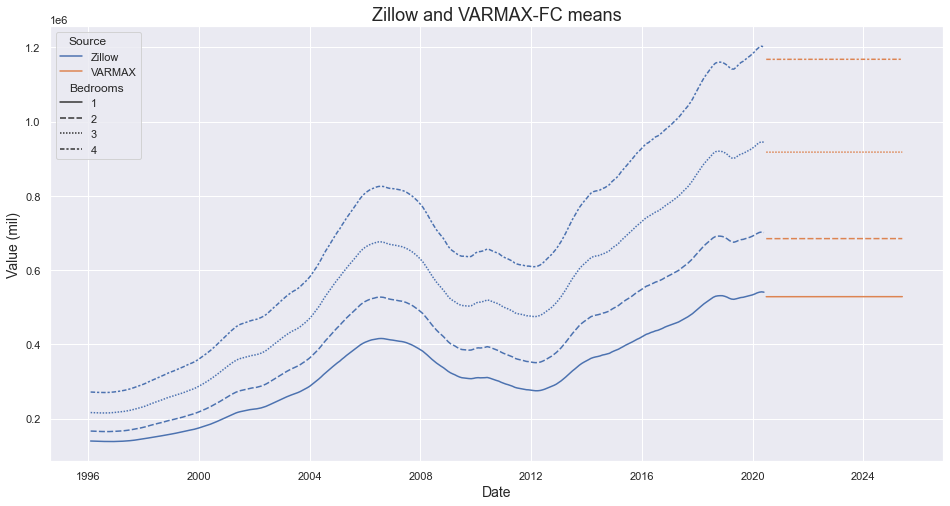

In [176]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and VARMAX-FC means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_and_VARMAX_FC_means.png')

VARMAX predictions are a straight line, but it looks like the line of best fit!

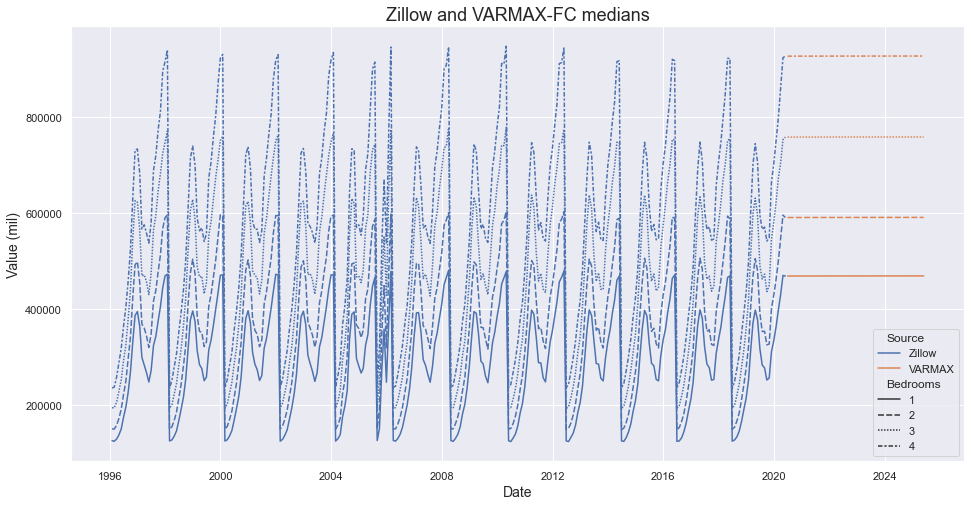

In [177]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow and VARMAX-FC medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_and_VARMAX_FC_medians.png')

In [43]:
# calculate the RMSE and MAE and store to csv
model_score = pd.DataFrame({
    'model':'VARMAX5-OneBR',
    'RMSE':mean_squared_error(test, pred_sub, squared=False),
    'MAE':mean_absolute_error(test, pred_sub),
    'fit_time(min)': '2',
}, index=[0])
model_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\varmax5_score_OneBR.csv',
                     index=False)
model_score

,model,RMSE,MAE,fit_time(min)
0,VARMAX5-OneBR,141155.5511,73654.9328,2
